In [ ]:
"""
    TODO
    1. 명칭 및 구조 통일화
    2. 그래프 및 그림 추가
    3. 피처 추가
"""

'\n    TODO\n    1. 명칭 및 구조 통일화\n    2. 그래프 및 그림 추가\n    3. 피처 추가\n'

In [1]:
# pip install optuna
!pip install optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 19.4 MB/s eta 0:00:00


In [2]:
pip install torch pandas numpy scikit-learn xgboost optuna matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import torch
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from xgboost.callback import EvaluationMonitor
import optuna
import matplotlib.pyplot as plt

In [4]:
try:
    CUDA = torch.cuda.is_available()
except:
    CUDA = False

print(f"CUDA available: {CUDA}")

CUDA available: False


In [5]:
from pathlib import Path

In [6]:
# -----------------------------
# 1) 경로 설정
# -----------------------------
TRAIN_FP = Path('train.csv')
TEST_DIR = Path('./')
SAMPLE_FP = Path('sample_submission.csv')

if not TRAIN_FP.exists() or not TEST_DIR.exists() or not SAMPLE_FP.exists():
    print("Path error: directory or file does not exist. Please check the paths.")
    print(f"Expected file path: {TRAIN_FP}")
    exit()
else:
    print("File paths are valid.")

File paths are valid.


In [7]:
# -----------------------------
# 2) 데이터 로드 및 전처리
# -----------------------------
print("Data loading and preprocessing...")

train = pd.read_csv('train.csv')
train["영업일자"] = pd.to_datetime(train["영업일자"])

print("Outlier handling using IQR...")

# 분포 비교를 위해 사본 보관
train_raw = train.copy()

# 이상치 처리 함수
def handle_outliers_iqr(df_group):
    non_zero_sales = df_group[df_group["매출수량"] > 0]["매출수량"]
    if len(non_zero_sales) < 5:
        return df_group

    q1, q3 = non_zero_sales.quantile(0.25), non_zero_sales.quantile(0.75)
    iqr = q3 - q1

    # 이상치 기준
    lower_bound = max(0, q1 - 1.5 * iqr)
    upper_bound = q3 + 1.5 * iqr

    df_group["매출수량"] = np.clip(df_group["매출수량"], lower_bound, upper_bound)
    return df_group

train = train.groupby("영업장명_메뉴명", group_keys=False).apply(handle_outliers_iqr)

print("Outlier handling complete")

tests = {}
for i in range(10):
    name = f"TEST_{i:02d}"
    df = pd.read_csv(TEST_DIR / f"{name}.csv")
    df["영업일자"] = pd.to_datetime(df["영업일자"])
    tests[name] = df
    print(f"[{name}] shape: {df.shape} | 날짜: {df['영업일자'].min().date()} ~ {df['영업일자'].max().date()}")

Data loading and preprocessing...
Outlier handling using IQR...
Outlier handling complete
[TEST_00] shape: (5404, 3) | 날짜: 2024-06-16 ~ 2024-07-13
[TEST_01] shape: (5404, 3) | 날짜: 2024-07-21 ~ 2024-08-17
[TEST_02] shape: (5404, 3) | 날짜: 2024-08-25 ~ 2024-09-21
[TEST_03] shape: (5404, 3) | 날짜: 2024-09-29 ~ 2024-10-26
[TEST_04] shape: (5404, 3) | 날짜: 2024-11-03 ~ 2024-11-30
[TEST_05] shape: (5404, 3) | 날짜: 2024-12-08 ~ 2025-01-04
[TEST_06] shape: (5404, 3) | 날짜: 2025-01-12 ~ 2025-02-08
[TEST_07] shape: (5404, 3) | 날짜: 2025-02-16 ~ 2025-03-15
[TEST_08] shape: (5404, 3) | 날짜: 2025-03-23 ~ 2025-04-19
[TEST_09] shape: (5404, 3) | 날짜: 2025-04-27 ~ 2025-05-24


/tmp/ipython-input-2310683134.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = train.groupby("영업장명_메뉴명", group_keys=False).apply(handle_outliers_iqr)


In [8]:
# -----------------------------
# 라이브러리 임포트
# -----------------------------
import pandas as pd
import numpy as np
from pathlib import Path

# -----------------------------
# 1) 경로 설정
# -----------------------------
TRAIN_FP = Path('train.csv')
TEST_DIR = Path('./')
SAMPLE_FP = Path('sample_submission.csv')

# -----------------------------
# 2) 데이터 로드 및 전처리
# -----------------------------
print("Data loading and preprocessing...")

train = pd.read_csv(TRAIN_FP)
train["영업일자"] = pd.to_datetime(train["영업일자"])

print("Outlier handling using IQR...")

train_raw = train.copy()  # 분포 비교용 원본 저장

# 이상치 처리 함수
def handle_outliers_iqr(df_group):
    non_zero_sales = df_group[df_group["매출수량"] > 0]["매출수량"]
    if len(non_zero_sales) < 5:
        return df_group

    q1, q3 = non_zero_sales.quantile(0.25), non_zero_sales.quantile(0.75)
    iqr = q3 - q1

    lower_bound = max(0, q1 - 1.5 * iqr)
    upper_bound = q3 + 1.5 * iqr

    df_group.loc[:, "매출수량"] = np.clip(df_group["매출수량"], lower_bound, upper_bound)
    return df_group

# 그룹별 이상치 처리
train = train.groupby("영업장명_메뉴명", group_keys=False).apply(handle_outliers_iqr)

print("✅ Outlier handling complete")

# Test 데이터 로드
tests = {}
for i in range(10):
    name = f"TEST_{i:02d}"
    df = pd.read_csv(TEST_DIR / f"{name}.csv")
    df["영업일자"] = pd.to_datetime(df["영업일자"])
    tests[name] = df
    print(f"[{name}] shape: {df.shape} | 날짜: {df['영업일자'].min().date()} ~ {df['영업일자'].max().date()}")


Data loading and preprocessing...
Outlier handling using IQR...
✅ Outlier handling complete
[TEST_00] shape: (5404, 3) | 날짜: 2024-06-16 ~ 2024-07-13
[TEST_01] shape: (5404, 3) | 날짜: 2024-07-21 ~ 2024-08-17
[TEST_02] shape: (5404, 3) | 날짜: 2024-08-25 ~ 2024-09-21
[TEST_03] shape: (5404, 3) | 날짜: 2024-09-29 ~ 2024-10-26
[TEST_04] shape: (5404, 3) | 날짜: 2024-11-03 ~ 2024-11-30
[TEST_05] shape: (5404, 3) | 날짜: 2024-12-08 ~ 2025-01-04
[TEST_06] shape: (5404, 3) | 날짜: 2025-01-12 ~ 2025-02-08
[TEST_07] shape: (5404, 3) | 날짜: 2025-02-16 ~ 2025-03-15
[TEST_08] shape: (5404, 3) | 날짜: 2025-03-23 ~ 2025-04-19
[TEST_09] shape: (5404, 3) | 날짜: 2025-04-27 ~ 2025-05-24


/tmp/ipython-input-806011811.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = train.groupby("영업장명_메뉴명", group_keys=False).apply(handle_outliers_iqr)


In [17]:
# -----------------------------
# 3) 피처 엔지니어링
# -----------------------------
print("Feature engineering...")

encoder = LabelEncoder()
train["item_id"] = encoder.fit_transform(train["영업장명_메뉴명"])

# 영업일자에서 날짜 관련 피처 생성
def make_date_feats(df):
    out = df.copy()
    out["year"], out["month"], out["day"], out["weekday"] = (
        out["영업일자"].dt.year,
        out["영업일자"].dt.month,
        out["영업일자"].dt.day,
        out["영업일자"].dt.weekday,
    )
    out["is_weekend"] = (
        out["weekday"].isin([5, 6]).astype(int)
    )

    # 주기적 특성 변환
    out["month_sin"], out["month_cos"] = np.sin(
        2 * np.pi * out["month"] / 12.0
    ), np.cos(2 * np.pi * out["month"] / 12.0)
    out["wday_sin"], out["wday_cos"] = np.sin(2 * np.pi * out["weekday"] / 7.0), np.cos(
        2 * np.pi * out["weekday"] / 7.0
    )
    return out

# 영업일자 피처 생성 및 정렬
train = make_date_feats(train)
train = train.sort_values(["item_id", "영업일자"])

for lag in [1, 7, 14, 28]:
    train[f"lag_{lag}"] = train.groupby("item_id")["매출수량"].shift(lag)

g = train.groupby("item_id")["매출수량"]
train["roll_mean_7"], train["roll_mean_14"], train["roll_std_7"] = (
    g.shift(1).rolling(7).mean(),
    g.shift(1).rolling(14).mean(),
    g.shift(1).rolling(7).std(),
)

train = train.dropna()
print("Feature engineering complete")

feature_cols = [
    "year",
    "month",
    "day",
    "weekday",
    "is_weekend",
    "month_sin",
    "month_cos",
    "wday_sin",
    "wday_cos",
    "item_id",
    "lag_1",
    "lag_7",
    "lag_14",
    "lag_28",
    "roll_mean_7",
    "roll_mean_14",
    "roll_std_7",
]

# =========================================
# [패치] 2024 가중치 + 특정 매장 가중치 + 인덱스 정렬
# =========================================

# 1) 기본 가중치
train['weight'] = 1.0

# 2) 특정 매장 가중치 (담하/미라시아) — 필요 시 값 조절
train.loc[train['영업장명_메뉴명'].str.contains('담하|미라시아', na=False), 'weight'] *= 2

# 3) 2024년 가중치
USE_RAMP_2024 = False  # True: 2024 안에서 연초→연말 선형증가(정교), False: 고정배수(간단)

mask_2024 = train['year'] == 2024

    # 고정 배수(간단): 2024 전체 ×1.5 (원하면 1.2~2.0 사이로 조절)
train.loc[mask_2024, 'weight'] *= 1.5

# (선택) 가중치 분포 확인
print("▶ weight 분포")
print(train['weight'].value_counts().sort_index())

# 4) 최종 학습 입력 구성 + 인덱스 정렬(중요)
X = train[feature_cols].reset_index(drop=True)
y = train["매출수량"].astype(float).reset_index(drop=True)
weights = train["weight"].astype(float).reset_index(drop=True)


Feature engineering...
Feature engineering complete
▶ weight 분포
weight
1.0    37080
1.5    20040
2.0    22557
3.0    12191
Name: count, dtype: int64


/tmp/ipython-input-3402402241.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["item_id"] = encoder.fit_transform(train["영업장명_메뉴명"])
/tmp/ipython-input-3402402241.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['weight'] = 1.0


In [18]:
# -----------------------------
# 4) Optuna를 이용한 하이퍼파라미터 튜닝 (가중치/재현성 반영 버전)
# -----------------------------
print("Optuna hyperparameter tuning...")

# 재현성 강화를 위한 전역 시드 (필요 시 상단 공통 영역으로 이동해도 무방)
import random
random.seed(42)
np.random.seed(42)

tscv = TimeSeriesSplit(n_splits=5)
splits = list(tscv.split(X))

# 검증 점수에 가중치 반영 여부 (True: 가중 RMSE, False: 비가중 RMSE)
USE_WEIGHTED_EVAL = True

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        # GPU의 미세한 비결정성 회피가 필요하면 'cpu' 권장
        "device": "cuda" if CUDA else "cpu",
        "seed": 42,
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
    }

    rmses = []
    for tr_idx, va_idx in splits:
        X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
        y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
        w_tr, w_va = weights.iloc[tr_idx], weights.iloc[va_idx]  # ← 2024/특정매장 가중치 반영

        dtr = xgb.DMatrix(X_tr, label=y_tr, weight=w_tr)
        if USE_WEIGHTED_EVAL:
            dva = xgb.DMatrix(X_va, label=y_va, weight=w_va)  # 평가도 가중
        else:
            dva = xgb.DMatrix(X_va, label=y_va)               # 평가 비가중

        cb = optuna.integration.XGBoostPruningCallback(trial, "val-rmse")
        model = xgb.train(
            params,
            dtr,
            num_boost_round=1000,
            evals=[(dva, "val")],
            early_stopping_rounds=50,
            callbacks=[cb],
            verbose_eval=False,
        )
        rmses.append(float(model.best_score))

    return float(np.mean(rmses))


# Optuna Sampler에 시드 고정(탐색 경로 재현성)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
    sampler=sampler,
)

warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message=r"The reported value is ignored because this `step` \d+ is already reported\."
)

study.optimize(objective, n_trials=50)

print(f"Best hyperparameter: {study.best_params}")
print(f"Best RMSE: {study.best_value}")


[I 2025-08-19 11:51:59,029] A new study created in memory with name: no-name-eb448fd0-4045-4db1-a948-f3e5f8728950


Optuna hyperparameter tuning...


[I 2025-08-19 11:52:01,739] Trial 0 finished with value: 21.439585901032494 and parameters: {'max_depth': 7, 'learning_rate': 0.2536999076681772, 'subsample': 0.892797576724562, 'colsample_bytree': 0.8394633936788146, 'gamma': 1.77071686435378e-07, 'lambda': 1.7699302940633311e-07, 'alpha': 2.9152036385288193e-08}. Best is trial 0 with value: 21.439585901032494.
[I 2025-08-19 11:52:14,326] Trial 1 finished with value: 22.24423131595662 and parameters: {'max_depth': 11, 'learning_rate': 0.07725378389307355, 'subsample': 0.8832290311184181, 'colsample_bytree': 0.608233797718321, 'gamma': 0.574485163632042, 'lambda': 0.04566054873446119, 'alpha': 4.997040685255803e-07}. Best is trial 0 with value: 21.439585901032494.
[I 2025-08-19 11:52:22,332] Trial 2 finished with value: 20.38795214120348 and parameters: {'max_depth': 5, 'learning_rate': 0.018659959624904916, 'subsample': 0.7216968971838151, 'colsample_bytree': 0.8099025726528951, 'gamma': 2.85469785779718e-05, 'lambda': 2.1371407316372

Best hyperparameter: {'max_depth': 4, 'learning_rate': 0.17707314089866105, 'subsample': 0.7061102847307473, 'colsample_bytree': 0.8665587058976357, 'gamma': 3.4080751640910644e-05, 'lambda': 0.0018039734498277286, 'alpha': 0.03400326234487508}
Best RMSE: 19.612689611267257


Model training with best hyperparameters...
[0]	val-rmse:72.13880
[10]	val-rmse:51.09089
[20]	val-rmse:49.43576
[30]	val-rmse:56.07175
[40]	val-rmse:56.03600
[50]	val-rmse:57.46066
[60]	val-rmse:56.91809
[70]	val-rmse:56.64828
[80]	val-rmse:56.14909
[90]	val-rmse:56.57015
[100]	val-rmse:56.60783
[110]	val-rmse:57.10231
[116]	val-rmse:57.19378
Best iteration: 17


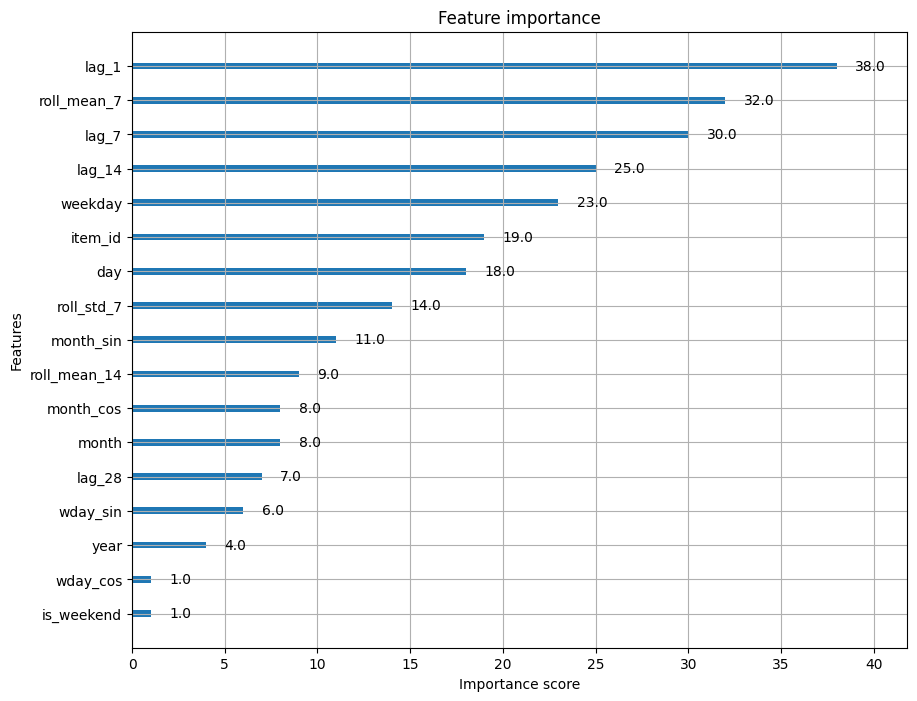

In [19]:
# -----------------------------
# 5) 최적 파라미터로 모델 학습
# -----------------------------
print("Model training with best hyperparameters...")

best_params = study.best_params
best_params.update(
    {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "tree_method": "hist",
        "device": "cuda" if CUDA else "cpu",
    }
)

# 최적 파라미터로 마지막 fold 학습
last_tr_idx, last_va_idx = list(tscv.split(X))[-1]
X_tr, X_va = X.iloc[last_tr_idx], X.iloc[last_va_idx]
y_tr, y_va = y.iloc[last_tr_idx], y.iloc[last_va_idx]
dtr, dva = xgb.DMatrix(X_tr, label=y_tr), xgb.DMatrix(X_va, label=y_va)
trained_model = xgb.train(
    best_params,
    dtr,
    num_boost_round=5000,
    evals=[(dva, "val")],
    early_stopping_rounds=100,
    verbose_eval=False,
    callbacks=[EvaluationMonitor(period=10)]
)
final_boost_round = trained_model.best_iteration

data_dmatrix = xgb.DMatrix(X, label=y, weight=weights)
final_model = xgb.train(
    best_params,
    data_dmatrix,
    num_boost_round=final_boost_round,
    verbose_eval=False
)

print(f"Best iteration: {final_boost_round}")

fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(final_model, ax=ax)
plt.show()

In [20]:
# -----------------------------
# 6) 재귀 예측
# -----------------------------
print("Recursive prediction...")
all_preds = []
full_history = train.copy()

# 중간 로그 누적용
step_logs = []

for test_name, test_df in tests.items():
    test_df = test_df.copy()
    test_df["item_id"] = encoder.transform(test_df["영업장명_메뉴명"])
    test_df = make_date_feats(test_df)

    # 학습 데이터와 테스트 데이터 병합
    history = pd.concat([full_history, test_df], ignore_index=True)
    history = history.sort_values(["item_id", "영업일자"])

    last_date = test_df["영업일자"].max()
    items = test_df["영업장명_메뉴명"].unique()

    preds_rows = []
    current_date = last_date
    for step in range(1, 8):
        target_date = current_date + pd.Timedelta(days=1)

        # 예측을 위한 데이터 프레임 생성
        frame = pd.DataFrame(
            {"영업일자": np.repeat(target_date, len(items)), "영업장명_메뉴명": items}
        )
        frame["item_id"] = encoder.transform(frame["영업장명_메뉴명"])
        frame = make_date_feats(frame)

        # 특징 계산
        temp_hist = history.copy()
        for lag in [1, 7, 14, 28]:
            lagged = temp_hist[["영업일자", "item_id", "매출수량"]].copy()
            lagged["영업일자"] = lagged["영업일자"] + pd.Timedelta(days=lag)
            frame = frame.merge(
                lagged.rename(columns={"매출수량": f"lag_{lag}"}),
                on=["영업일자", "item_id"],
                how="left",
            )

        roll_base = temp_hist.sort_values(["item_id", "영업일자"]).copy()
        gb = roll_base.groupby("item_id")["매출수량"]
        roll_base["roll_mean_7"] = gb.rolling(7).mean().reset_index(0, drop=True)
        roll_base["roll_mean_14"] = gb.rolling(14).mean().reset_index(0, drop=True)
        roll_base["roll_std_7"] = gb.rolling(7).std().reset_index(0, drop=True)
        roll_base["영업일자"] = roll_base["영업일자"] + pd.Timedelta(days=1)
        frame = frame.merge(
            roll_base[
                ["영업일자", "item_id", "roll_mean_7", "roll_mean_14", "roll_std_7"]
            ],
            on=["영업일자", "item_id"],
            how="left",
        )

        # 결측치 채우기 전/후 카운트 집계
        nan_before = int(frame[feature_cols].isna().sum().sum())
        frame[feature_cols] = frame[feature_cols].fillna(0)
        nan_after = int(frame[feature_cols].isna().sum().sum())
        # frame[feature_cols] = frame[feature_cols].fillna(0)

        # 예측 수행
        X_pred = frame[feature_cols]
        dpred = xgb.DMatrix(X_pred)
        yhat = final_model.predict(dpred)
        yhat = np.clip(yhat, 0, None)
        frame["pred"] = yhat

        # step별 요약 프린트 & 로그 저장
        pred_sum = float(yhat.sum())
        pred_mean = float(yhat.mean())
        pred_std = float(yhat.std() if len(yhat) else 0.0)
        print(
            f"[{test_name}] step {step} | date={target_date.date()} | "
            f"rows={len(frame):,} | NaN(before→after)={nan_before}->{nan_after} | "
            f"pred_sum={pred_sum:,.2f} | pred_mean={pred_mean:.3f} | pred_std={pred_std:.3f}"
        )
        step_logs.append({
            "test": test_name,
            "step": step,
            "target_date": target_date,
            "rows": int(len(frame)),
            "nan_before": nan_before,
            "nan_after": nan_after,
            "pred_sum": pred_sum,
            "pred_mean": pred_mean,
            "pred_std": pred_std,
        })

        # 이전 예측 결과를 history에 추가해 재귀
        add_hist = frame[["영업일자", "item_id", "영업장명_메뉴명", "pred"]].rename(
            columns={"pred": "매출수량"}
        )
        history = pd.concat([history, add_hist], ignore_index=True)

        # 결과 저장
        frame_out = frame[["영업일자", "영업장명_메뉴명", "pred"]].copy()
        frame_out["영업일자"] = f"{test_name}+{step}일"
        preds_rows.append(frame_out)

        current_date = target_date

    test_pred = pd.concat(preds_rows, ignore_index=True)
    wide = test_pred.pivot(index="영업일자", columns="영업장명_메뉴명", values="pred")
    all_preds.append(wide)

print("Prediction complete")

Recursive prediction...
[TEST_00] step 1 | date=2024-07-14 | rows=193 | NaN(before→after)=0->0 | pred_sum=1,166.35 | pred_mean=6.043 | pred_std=14.352
[TEST_00] step 2 | date=2024-07-15 | rows=193 | NaN(before→after)=0->0 | pred_sum=673.93 | pred_mean=3.492 | pred_std=5.364
[TEST_00] step 3 | date=2024-07-16 | rows=193 | NaN(before→after)=0->0 | pred_sum=780.12 | pred_mean=4.042 | pred_std=7.470
[TEST_00] step 4 | date=2024-07-17 | rows=193 | NaN(before→after)=0->0 | pred_sum=744.36 | pred_mean=3.857 | pred_std=6.233
[TEST_00] step 5 | date=2024-07-18 | rows=193 | NaN(before→after)=0->0 | pred_sum=885.65 | pred_mean=4.589 | pred_std=8.285
[TEST_00] step 6 | date=2024-07-19 | rows=193 | NaN(before→after)=0->0 | pred_sum=1,057.78 | pred_mean=5.481 | pred_std=10.816
[TEST_00] step 7 | date=2024-07-20 | rows=193 | NaN(before→after)=0->0 | pred_sum=1,268.55 | pred_mean=6.573 | pred_std=10.892
[TEST_01] step 1 | date=2024-08-18 | rows=193 | NaN(before→after)=0->0 | pred_sum=1,004.44 | pred_m

In [21]:
# -----------------------------
# 0) 샘플 제출 파일 로드
# -----------------------------
sample = pd.read_csv("sample_submission.csv")

# -----------------------------
# 7) 최종 제출 파일 생성
# -----------------------------
submission = pd.concat(all_preds)
submission = submission.reset_index().rename(columns={"index": "영업일자"})
submission = submission[sample.columns]   # sample과 같은 컬럼 순서로 맞춤
out_path = 'submission_xgboost_weight.csv'
submission.to_csv(out_path, index=False, encoding="utf-8-sig")

print(f"Submission file created: {out_path}")


Submission file created: submission_xgboost_5.csv


In [22]:
import pandas as pd
import numpy as np
from IPython.display import display

# ==============================================================================
# 1. 설정 및 데이터 로드
# ==============================================================================
# [사용자 수정 필요] 파일 경로
#SUBMISSION_PATH = 'submission_wide_format.csv'
SUBMISSION_PATH = 'submission_xgboost_5.csv'
TRAIN_PATH = 'train.csv'

try:
    submission_df = pd.read_csv(SUBMISSION_PATH)
    train_df = pd.read_csv(TRAIN_PATH)
    print("✅ 평가 대상 파일(submission.csv, train.csv) 로드 완료.")
except FileNotFoundError:
    print("❌ 오류: 평가에 필요한 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    submission_df, train_df = None, None

# ==============================================================================
# 2. 평가 함수 정의
# ==============================================================================
def weighted_smape(y_true, y_pred, weights):
    """
    가중치가 적용된 SMAPE를 계산하고 100점 만점으로 변환하는 함수.
    """
    # 실제값이 0인 데이터 필터링
    non_zero_mask = y_true != 0
    y_true_f = y_true[non_zero_mask]
    y_pred_f = y_pred[non_zero_mask]
    weights_f = weights[non_zero_mask]

    # SMAPE 계산
    numerator = np.abs(y_pred_f - y_true_f)
    denominator = (np.abs(y_true_f) + np.abs(y_pred_f))

    # 분모가 0이 되는 경우 방지 (y_true, y_pred 모두 0)
    # 위 필터로 y_true가 0인 경우는 제외되었으므로, y_pred만 0이어도 분모는 0이 아님
    element_wise_smape = 2 * numerator / denominator

    # 가중 평균 계산
    weighted_smape_score = np.sum(element_wise_smape * weights_f) / np.sum(weights_f)

    # 100점 만점 기준으로 변환
    return 100 * (1 - weighted_smape_score)

# ==============================================================================
# 3. 평가 실행 블록
# ==============================================================================
if submission_df is not None and train_df is not None:

    # --- 1. 데이터 전처리 ---
    # submission_df를 Long 포맷으로 변환
    pred_long = pd.melt(submission_df, id_vars=['영업일자'], var_name='영업장명_메뉴명', value_name='예측값')

    # train_df의 날짜 타입 변환
    train_df['영업일자'] = pd.to_datetime(train_df['영업일자'])

    # submission의 'TEST_XX+Y일'을 train의 실제 날짜와 매칭시키기 위한 가상 날짜 생성
    # (실제 평가에서는 이 부분이 주최측의 비공개 로직에 따라 달라짐)
    # 여기서는 train 데이터의 마지막 날짜 이후로 가정하여 매칭
    last_train_date = train_df['영업일자'].max()
    test_base_dates = {f'TEST_{i:02d}': last_train_date - pd.to_timedelta((9-i)*7 + 27, unit='d') for i in range(10)}

    def map_to_real_date(date_id):
        test_num = date_id.split('+')[0]
        day_offset = int(date_id.split('+')[1].replace('일', ''))
        return test_base_dates[test_num] + pd.to_timedelta(day_offset, unit='d')

    pred_long['실제영업일자'] = pred_long['영업일자'].apply(map_to_real_date)

    # --- 2. 실제값과 예측값 병합 ---
    eval_df = pd.merge(
        train_df,
        pred_long,
        left_on=['영업장명_메뉴명', '영업일자'],
        right_on=['영업장명_메뉴명', '실제영업일자'],
        how='inner' # 일치하는 날짜와 메뉴만 평가
    )

    if eval_df.empty:
        print("\n⚠️ 경고: 예측 기간과 일치하는 실제값 데이터가 train.csv에 없습니다. 점수를 계산할 수 없습니다.")
    else:
        # --- 3. 가중치 부여 ---
        eval_df['영업장명'] = eval_df['영업장명_메뉴명'].str.split('_').str[0]
        # '담하', '미라시아'에 가중치 2, 나머지에 1 부여 (임의 설정)
        eval_df['가중치'] = np.where(eval_df['영업장명'].isin(['담하', '미라시아']), 2.0, 1.0)

        # --- 4. 점수 계산 ---
        y_true = eval_df['매출수량']
        y_pred = eval_df['예측값']
        weights = eval_df['가중치']

        # Public Score (50% 샘플링)
        public_sample = eval_df.sample(frac=0.5, random_state=42)
        public_score = weighted_smape(public_sample['매출수량'], public_sample['예측값'], public_sample['가중치'])

        # Private Score (100% 데이터)
        private_score = weighted_smape(y_true, y_pred, weights)

        print("\n" + "="*50)
        print("             리더보드 평가 점수 (모의 테스트)")
        print("="*50)
        print(f"Public Score  : {public_score:.4f}")
        print(f"Private Score : {private_score:.4f}")
        print("="*50)

✅ 평가 대상 파일(submission.csv, train.csv) 로드 완료.

             리더보드 평가 점수 (모의 테스트)
Public Score  : 29.7159
Private Score : 28.5287
